In [2]:
import csv
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import scipy
import tensorflow as tf
import time
import uproot
# import zfit

In [3]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    for i in range(n_processes):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

def read_slice(files, slices, index, expressions, cut, data):
    data_slice = []
    for i in range(slices[index][0], slices[index][2] + 1):
        data_slice.append(files[i].arrays(expressions=expressions, 
                              cut=cut,
                              entry_start=slices[index][1] if i == slices[index][0] else None,
                              entry_stop=slices[index][3] if i == slices[index][2] else None,
                              library="pd"))
    data.append(pd.concat(data_slice))

def to_pandas(path, tree, n_files, n_processes, expressions, cut=None):
    files = [uproot.open(path=path + filename + ":" + tree) for filename in sorted(os.listdir(path))[:n_files]]
    slices = partition(files, n_processes)
    data = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_slice, args=[files, slices, i, expressions, cut, data])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    return pd.concat(data)

In [4]:
path = "../data/128_files/"

In [7]:
start = time.time()
data = to_pandas(path, "rootuple/CandidateTree", 128, 64, 
                "candidate_vMass",
                "(candidate_charge == 0)\
                & (candidate_cosAlpha > 0.99)\
                & (candidate_lxy / candidate_lxyErr > 3.0)\
                & (candidate_vProb > 0.05)\
                & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)"
                )
time.time() - start

18.402955770492554

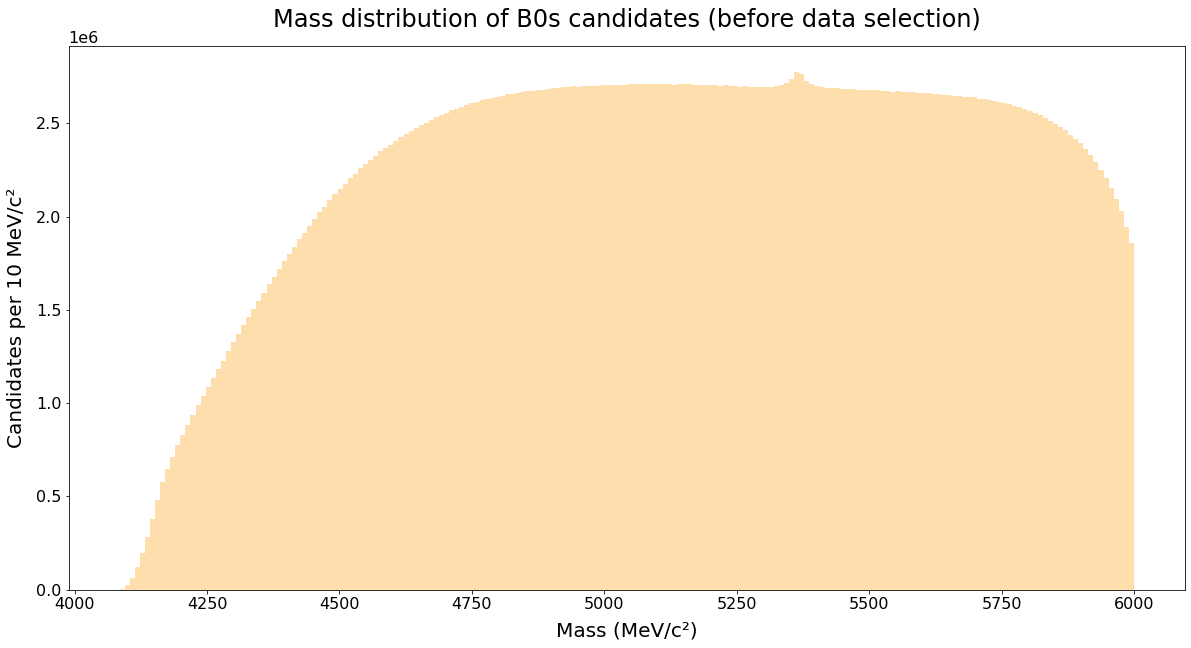

In [60]:
plt.figure(figsize=(20, 10))
plt.title("Mass distribution of B0s candidates (before data selection)", fontsize=24, pad=20)
plt.xlabel("Mass (MeV/c²)", fontsize=20, labelpad=10)
plt.ylabel("Candidates per 10 MeV/c²", fontsize=20, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('font', **{'size':'16'})
plt.hist(data["candidate_vMass"] * 1000, bins=200, color="navajowhite")
plt.show()

In [7]:
def parameter(name, value, lower=None, upper=None):
    try:
        return zfit.Parameter(name, value, lower, upper)
    except zfit.exception.NameAlreadyTakenError:
        del zfit.Parameter._existing_params[name]
        return zfit.Parameter(name, value, lower, upper)

In [8]:
mass = zfit.Space('candidate_vMass', limits=(5.33, 5.4))

mu = parameter("mu", 5.37, 5.33, 5.4)
sigma = parameter("sigma", 0.01, 0.001, 0.2)
signal = zfit.pdf.Gauss(obs=mass, mu=mu, sigma=sigma)

a0 = parameter("a0", 0.5, 0.0, 1.0)
a1 = parameter("a1", -0.3, -0.5, 1.0)
bkg = zfit.pdf.Chebyshev(obs=mass, coeffs=[a0, a1])

fraction = parameter("fraction", 0.5, 0, 1)

model = zfit.pdf.SumPDF([signal, bkg], fraction)

In [9]:
nll = zfit.loss.UnbinnedNLL(model=model, data=zfit.Data.from_pandas(data))  # loss

minimizer = zfit.minimize.Minuit()
minimum = minimizer.minimize(loss=nll)

print(minimum)

/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/zfit/core/loss.py:205: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['inconsistent_fitrange']` = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDFs [<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, fraction]] as well as `data` [<zfit.core.data.Data object at 0x7f3e2c70b3d0>] have different ranges [(<zfit Space obs=('candidate_vMass',), axes=(0,), limits=(array([[5.33]]), array([[5.4]]))>, <zfit Space obs=('candidate_vMass',), axes=(0,), limits=None>)] they are defined in. The data range will cut the data while the norm range defines the normalization.
  warn_advanced_feature(f"PDFs {non_consistent['model']} as "


FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, fraction]] data=[<zfit.core.data.Data object at 0x7f3e2c70b3d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.2e-06 │ -7740       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value    at limit
--------  --------  ----------
fraction    0.4156       False
mu           5.367       False
sigma     0.008588       False
a0         0.02811       False
a1         -0.3602       False


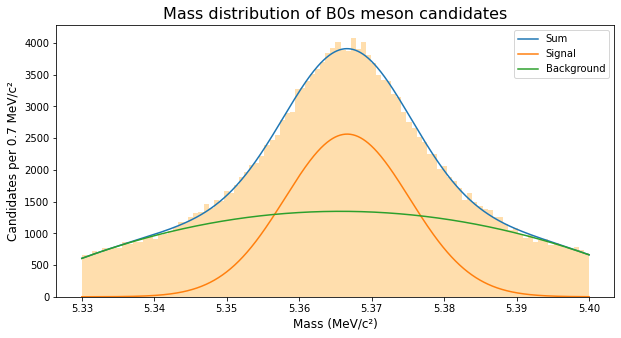

In [28]:
mass_range = (5.33, 5.4)
n_bins = 100

plt.figure(figsize=(10, 5))
plt.title("Mass distribution of B0s meson candidates", fontsize=16)
plt.xlabel("Mass (MeV/c²)", fontsize=12)
plt.ylabel("Candidates per 0.7 MeV/c²", fontsize=12)
plt.hist(data["candidate_vMass"], bins=n_bins, color="navajowhite")

mass = np.linspace(*mass_range, num=1000)

pdf = zfit.run(model.pdf(mass))
gauss = (signal.pdf(mass) * fraction).numpy()
chebyshev = (bkg.pdf(mass) * (1 - fraction)).numpy()

scale = len(data["candidate_vMass"]) / n_bins * (mass_range[1] - mass_range[0])

plt.plot(mass, pdf * scale, label="Sum")
plt.plot(mass, gauss * scale, label="Signal")
plt.plot(mass, chebyshev * scale, label="Background")
plt.legend()